In [1]:
# move to the folder with dataset
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Ifeanyi/toyota_model_recognition

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Ifeanyi/toyota_model_recognition


The TensorFlow Lite Model Maker library simplifies the process of adapting and converting a TensorFlow neural-network model to particular input data when deploying this model for on-device ML applications.

### Prerequisite

we first need to install several required packages, including Model Maker package that is in this GitHub [repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

In [2]:
!pip install -q tflite-model-maker

Import the required packages.

In [3]:
# Import required packages
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import image_classifier
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

# Get the data path

The data needs to be arranged in an order whereby all images that belongs to a particular class are stored in a subdirectory and a single parent directory holds all subdirectories.  
The names of the subdirectories are used as the data labels

In [4]:
import pathlib
image_path = pathlib.Path('./images/') 

Use DataLoader class to load data.

As for from_folder() method, it could load data from the folder. It assumes that the image data of the same class are in the same subdirectory and the subfolder name is the class name. Currently, JPEG-encoded images and PNG-encoded images are supported.


Split it to training data (91%), and testing data (9%), from 1,100 images

In [5]:
data = DataLoader.from_folder(image_path)
train_data, test_data = data.split(0.91)

INFO:tensorflow:Load image with size: 1100, num_label: 10, labels: toyota_4runner, toyota_avalon, toyota_camry, toyota_corolla, toyota_fjcruiser, toyota_hiace, toyota_hilux, toyota_landcruiser, toyota_rav4, toyota_sienna.


Show 25 image examples with labels.

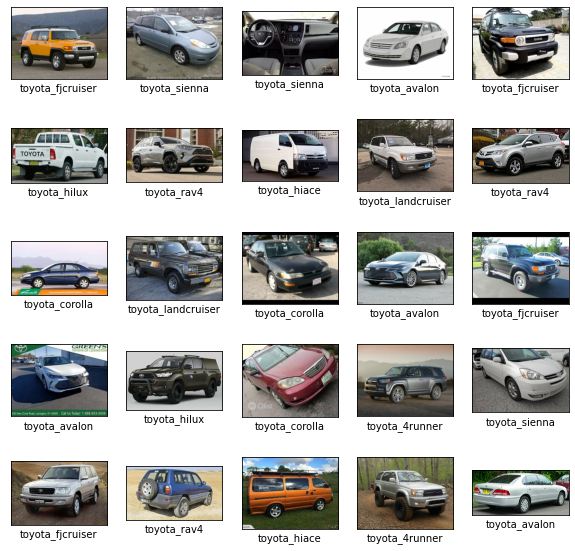

In [6]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

# Step 2: Customize the TensorFlow Model
Create a custom image classifier model based on the loaded data. The default model is EfficientNet-Lite0. The model is trained for 50 epochs

In [7]:
model = image_classifier.create(train_data, validation_data=test_data, epochs=50)

INFO:tensorflow:Retraining the models...


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              3413024   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 3,425,834
Trainable params: 12,810
Non-trainable params: 3,413,024
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
31/31 [==============================] - 29s 776ms/step - loss: 2.2094 - accuracy: 0.2077 - val_loss: 1.8120 - val_accuracy: 0.3958
Epoch 2/50
31/31 [==============================] - 23s 770ms/step - loss: 1.6857 - accuracy: 0.4688 - val_loss: 1.5793 - val_accuracy: 0.5417
Epoch 3/50
31/31 [==============================] - 24s 813ms/step - loss: 1.4921 - accuracy: 0.5595 - val_loss: 1.4822 - val_accuracy: 0.5625
Epoch 4/50
31/31 [==============================] - 25s 813ms/step - loss: 1.3908 - accuracy: 0.6361 - val_loss: 1.4331 - val_accuracy: 0.6146
Epoch 5/50
31/31 [==============================] - 21s 699ms/step - loss: 1.3301 - accuracy: 0.6623 - val_loss: 1.3832 - val_accuracy: 0.6250
Epoch 6/50
31/31 [==============================] - 22s 715ms/step - loss: 1.2777 - accuracy: 0.6895 - val_loss: 1.3558 - val_accuracy: 0.6354
Epoch 7/50
31/31 [==============================] - 21s 697ms/step - loss: 1.2287 - accuracy: 0.7137 - val_loss: 1.3431 - val_accuracy: 0.6354

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              3413024   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 3,425,834
Trainable params: 12,810
Non-trainable params: 3,413,024
_________________________________________________________________


# Step 3: Evaluate the Customized Model
Evaluate the result of the model on the test set, get the loss and accuracy of the model.

In [9]:
loss, accuracy = model.evaluate(test_data)

4/4 [==============================] - 6s 538ms/step - loss: 1.1633 - accuracy: 0.7172


# Step 4: Export to TensorFlow Lite Model
Convert the trained model to TensorFlow Lite model format with metadata so that you can later use in an on-device ML application. The label file and the vocab file are embedded in metadata. The default TFLite filename is `model.tflite`.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you apply quantize the model to make it smaller and potentially run faster. The default post-training quantization technique is full interger quantization for the image classification task.

In [10]:
export_dir = './model_dir/'
model.export(export_dir=export_dir)

INFO:tensorflow:Assets written to: /tmp/tmpjkn5otz7/assets


INFO:tensorflow:Assets written to: /tmp/tmpjkn5otz7/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmpzht7fohy/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmpzht7fohy/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_dir/model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model_dir/model.tflite


### You can also evaluate the exported tflite model with the `evaluate_tflite` method.

In [11]:
model.evaluate_tflite('./model_dir/model.tflite', test_data)

{'accuracy': 0.7272727272727273}

# Customize Post-training quantization on the TensorFLow Lite model
[Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) is a conversion technique that can reduce model size and inference latency, while also improving CPU and hardware accelerator inference speed, with a little degradation in model accuracy. Thus, it's widely used to optimize the model.

Model Maker library applies a default post-training quantization techique when exporting the model. If you want to customize post-training quantization, Model Maker supports multiple post-training quantization options using [QuantizationConfig](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/config/QuantizationConfig) as well. Let's take float16 quantization as an instance. First, define the quantization config.

***PS:*** **For this model, we have a small very dataset, therefore we lay emphasis on accuracy. Therefor we won't be applying this quantization technique **

In [12]:
#config = QuantizationConfig.for_float16()

Then we export the TensorFlow Lite model with such configuration.

In [13]:
#model.export(export_dir=export_dir, tflite_filename='model_fp16.tflite', quantization_config=config)

# Create a function to predict a single image

In [14]:
# import image processing package
from keras.preprocessing import image

# create function predicting singular image with .tflite model
def predict(interpreter, imagefile):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    test_image = image.load_img(imagefile, target_size = (224, 224))
    test_image = image.img_to_array(test_image).astype(np.uint8)
    test_image = np.expand_dims(test_image, axis=0)
    print(test_image.max())

    interpreter.set_tensor(input_details[0]['index'], test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_details[0]['index'])
    digit = np.argmax(output()[0])
    print('--->>>', digit)
    
    predict = {0: 'Toyota 4runner', 1: 'Toyota Avalon', 2: 'Toyota_Camry', 3: 'Toyota Corolla', 4: 'Toyota FJCruiser', 5: 'Toyota Hiace',
    6: 'Toyota Hilux', 7: 'Toyota LandCruiser', 8: 'Toyota Rav4', 9: 'Toyota Sienna'}
  
    return 'The Car Model Is {}!'.format(predict.get(digit))

In [15]:
interpreter = tf.lite.Interpreter(model_path="./model_dir/model.tflite")
interpreter.allocate_tensors()

In [16]:
predict(interpreter, './output/val/toyota_landcruiser/09edb22651.jpg')

255
--->>> 7


'The Car Model Is Toyota LandCruiser!'

### This notebook was executed with the help of the [this tensorflow tutorial](https://www.tensorflow.org/lite/tutorials/model_maker_image_classification#scrollTo=zNDBP2qA54aK)
